In [24]:
import pandas as pd
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv('Juneau_field_data.csv')

# 将日期列转换为 datetime 格式
data['Date'] = pd.to_datetime(data['Date'], format='%Y')

# 准备预测的变量
variables = ['air quality index', 'greenhouse gas emissions', 'Methane emissions', 'Glacier area', 'carbon dioxide emission']


In [25]:
# 使用 Prophet 进行预测
def prophet_predict(df, column, periods=5):
    df_prophet = df[['Date', column]].rename(columns={'Date': 'ds', column: 'y'})
    model = Prophet(yearly_seasonality=True)
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=periods, freq='Y')
    forecast = model.predict(future)
    return forecast[['ds', 'yhat']]

# 使用 LSTM 进行预测
def lstm_predict(df, column, look_back=3, forecast_years=5):
    # 准备数据
    dataset = df[column].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    # 创建时间序列数据集
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    X = np.array(X)
    Y = np.array(Y)
    
    # 构建 LSTM 模型
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # 训练模型
    model.fit(X.reshape(X.shape[0], X.shape[1], 1), Y, epochs=100, batch_size=1, verbose=0)
    
    # 预测未来
    predictions = []
    last_sequence = dataset[-look_back:]
    for _ in range(forecast_years):
        pred = model.predict(last_sequence.reshape(1, look_back, 1))
        predictions.append(pred.flatten())  # 将预测结果展平为一维
        
        # 更新序列
        last_sequence = np.append(last_sequence[1:], pred, axis=0)
    
    predictions = np.array(predictions).reshape(-1, 1)  # 转换为二维数组
    predictions = scaler.inverse_transform(predictions).flatten()
    
    prediction_years = [df['Date'].max().year + i + 1 for i in range(forecast_years)]
    return pd.DataFrame({'ds': prediction_years, 'yhat': predictions})

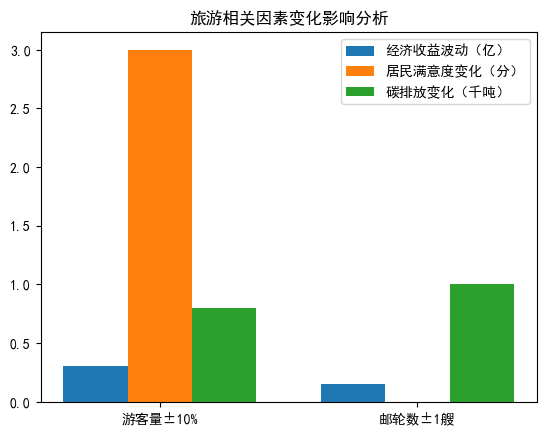

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 定义变量名称
variables = ["游客量±10%", "邮轮数±1艘"]

# 定义经济收益、居民满意度、碳排放的变化数据
economic_impact = [0.3, 0.15]
satisfaction_impact = [3, 0]
carbon_impact = [0.8, 1]

# 设置柱状图宽度
bar_width = 0.25

# 设置x轴位置
r1 = np.arange(len(variables))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# 绘制柱状图
plt.bar(r1, economic_impact, width=bar_width, label='经济收益波动（亿）')
plt.bar(r2, satisfaction_impact, width=bar_width, label='居民满意度变化（分）')
plt.bar(r3, carbon_impact, width=bar_width, label='碳排放变化（千吨）')

# 添加x轴标签
plt.xticks([r + bar_width for r in range(len(variables))], variables)

# 添加图例
plt.legend()

# 添加标题
plt.title('旅游相关因素变化影响分析')

# 显示图形
plt.show()


In [26]:
# 可视化函数
def plot_predictions(actual_data, prophet_result, lstm_result, variable_name):
    
    # 确保 Prophet 和 LSTM 结果中的日期列是 datetime 格式
    prophet_result['ds'] = pd.to_datetime(prophet_result['ds'])
    lstm_result['ds'] = pd.to_datetime(lstm_result['ds'])
    plt.figure(figsize=(12, 6))

    # 绘制历史数据
    plt.plot(actual_data['Date'], actual_data[variable_name], label='Actual', marker='o')

    # 绘制 Prophet 预测结果
    plt.plot(prophet_result['ds'], prophet_result['yhat'], label='Prophet Forecast', linestyle='--')

    # 绘制 LSTM 预测结果
    plt.plot(lstm_result['ds'], lstm_result['yhat'], label='LSTM Forecast', linestyle='--')

    plt.title(f"Predictions for {variable_name}")
    plt.xlabel("Year")
    plt.ylabel(variable_name)
    plt.legend()
    plt.grid(True)
    plt.show()

In [27]:
# 保存预测结果到 CSV 文件
def save_predictions_to_csv(results, filename='predictions.csv'):
    # 将所有结果合并到一个 DataFrame 中
    all_results = []
    for variable, result in results.items():
        result['Variable'] = variable
        all_results.append(result)
    
    # 合并所有结果
    combined_results = pd.concat(all_results, ignore_index=True)
    
    # 保存到 CSV
    combined_results.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

19:01:13 - cmdstanpy - INFO - Chain [1] start processing
19:01:13 - cmdstanpy - INFO - Chain [1] done processing


1/1 [==============================] - 0s 15ms/step


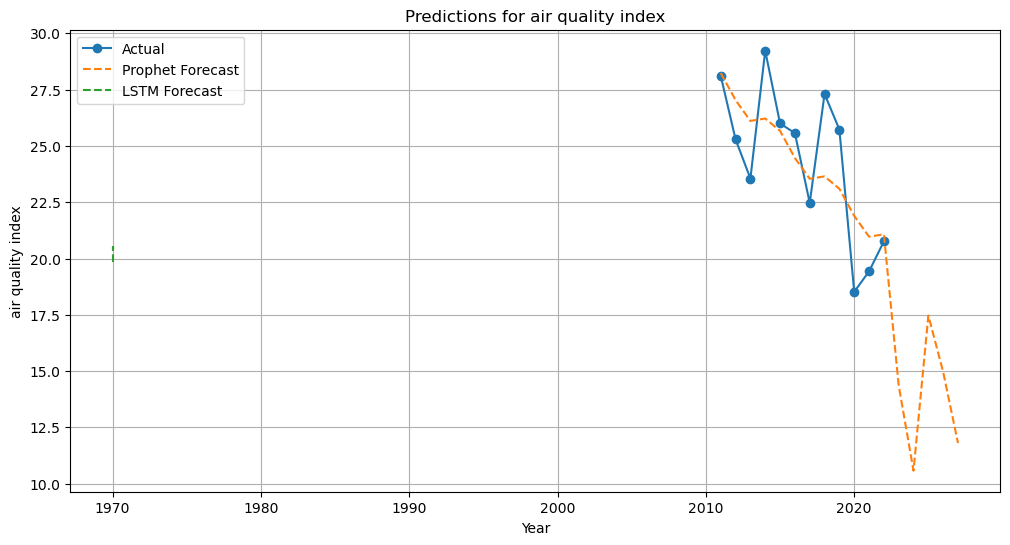

19:01:18 - cmdstanpy - INFO - Chain [1] start processing
19:01:18 - cmdstanpy - INFO - Chain [1] done processing


1/1 [==============================] - 0s 17ms/step


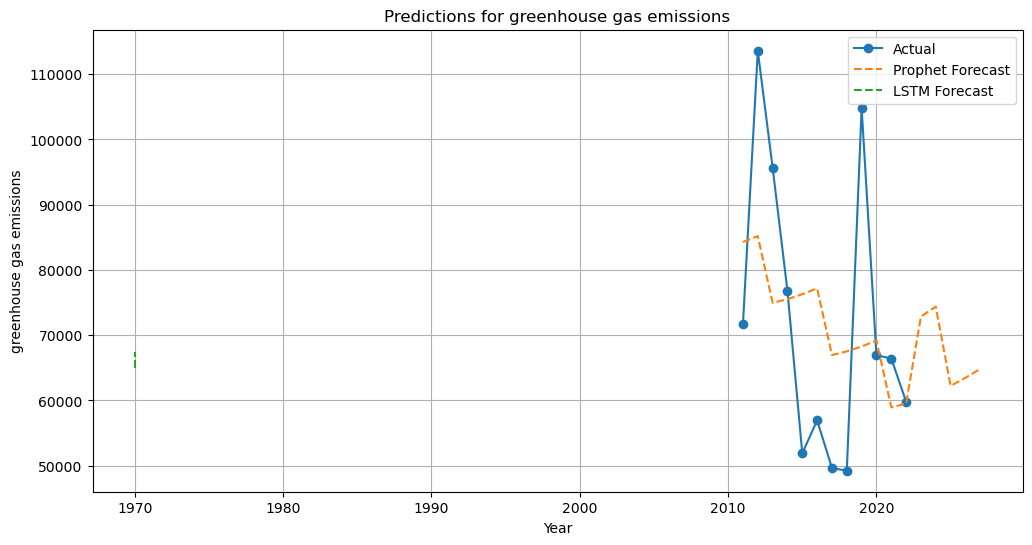

19:01:24 - cmdstanpy - INFO - Chain [1] start processing
19:01:24 - cmdstanpy - INFO - Chain [1] done processing


1/1 [==============================] - 0s 23ms/step


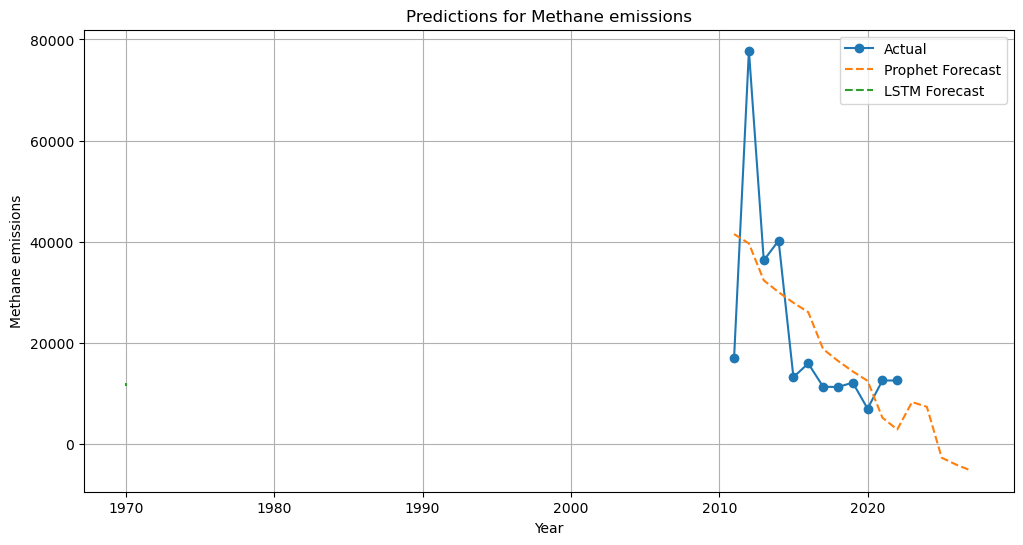

19:01:30 - cmdstanpy - INFO - Chain [1] start processing
19:01:38 - cmdstanpy - INFO - Chain [1] done processing


1/1 [==============================] - 0s 18ms/step


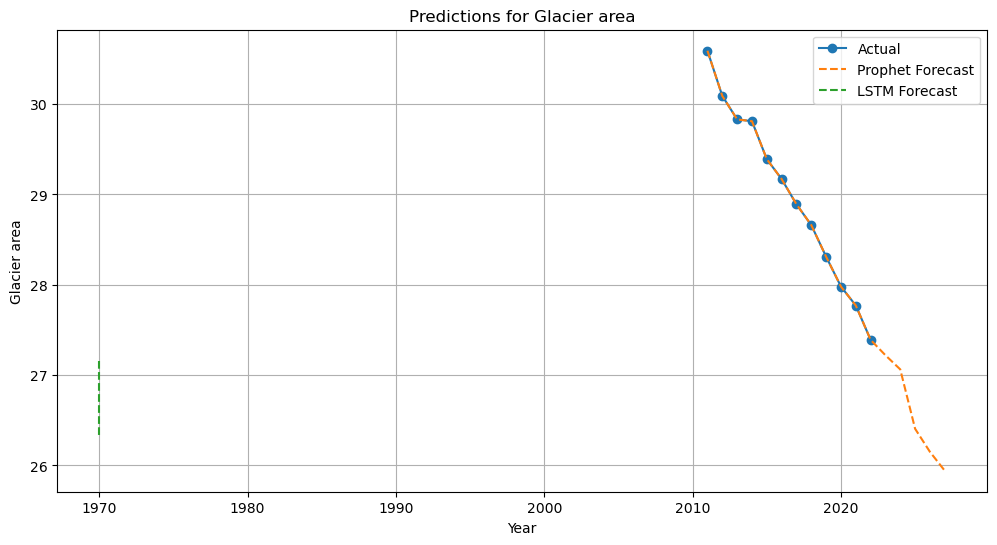

19:01:44 - cmdstanpy - INFO - Chain [1] start processing
19:01:44 - cmdstanpy - INFO - Chain [1] done processing


1/1 [==============================] - 0s 17ms/step


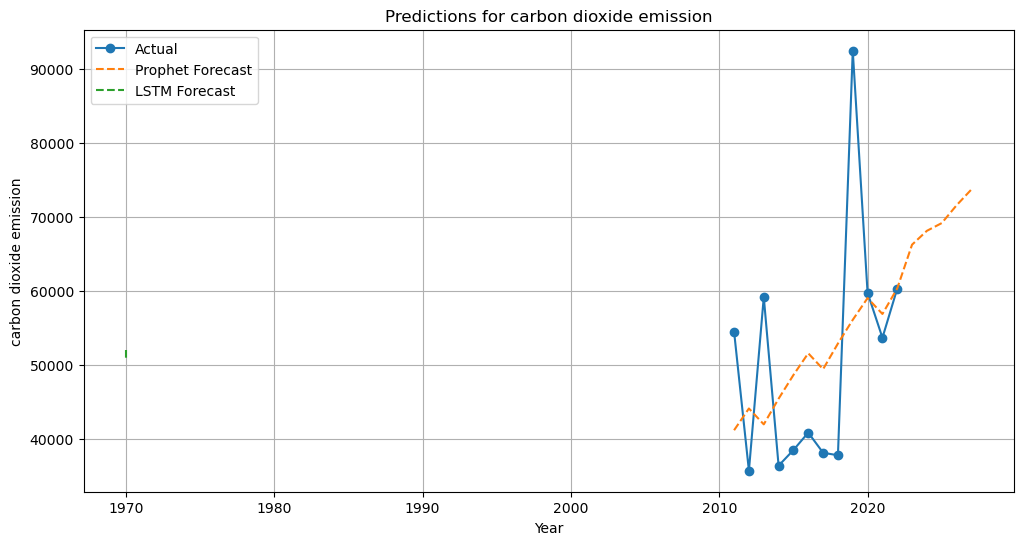

Predictions saved to predictions.csv


In [28]:
# 进行预测
results = {}
# 打印和可视化预测结果
# 进行预测并保存结果
for var in variables:
    prophet_result = prophet_predict(data, var)
    lstm_result = lstm_predict(data, var)
    
    # 合并结果
    final_result = pd.DataFrame({
        'Date': prophet_result['ds'],
        'Prophet': prophet_result['yhat'],
        'LSTM': lstm_result['yhat']
    })
    results[var] = final_result

    # 可视化
    plot_predictions(data, prophet_result, lstm_result, var)

# 保存预测结果到 CSV 文件
save_predictions_to_csv(results)